In [8]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime

In [2]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

2024-06-23 01:56:56.504772: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-23 01:56:56.769951: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 01:56:57.535285: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
df = pd.read_csv('/home/thu/LaptrinhAI/Final_term/hanoi-aqi-weather-data.csv',
                 parse_dates=['Local Time', 'UTC Time'],
                 index_col=['Local Time'])
df.head()

,UTC Time,City,Country Code,Timezone,AQI,CO,NO2,O3,PM10,PM25,SO2,Clouds,Precipitation,Pressure,Relative Humidity,Temperature,UV Index,Wind Speed
Local Time,,,,,,,,,,,,,,,,,,
2023-06-08 00:00:00,2023-06-07 17:00:00,Hanoi,VN,Asia/Ho_Chi_Minh,118,168.7,32.3,74.7,52.5,42.0,57.3,37,0.5,1004,87,29.3,0.0,1.33
2023-06-08 01:00:00,2023-06-07 18:00:00,Hanoi,VN,Asia/Ho_Chi_Minh,115,169.8,32.0,66.0,51.3,41.0,64.0,50,1.0,1004,88,29.0,0.0,1.00
2023-06-08 02:00:00,2023-06-07 19:00:00,Hanoi,VN,Asia/Ho_Chi_Minh,112,166.7,29.3,63.7,50.0,40.0,66.0,62,1.0,1003,89,28.9,0.0,0.66
2023-06-08 03:00:00,2023-06-07 20:00:00,Hanoi,VN,Asia/Ho_Chi_Minh,121,163.6,26.7,61.3,53.8,43.0,68.0,75,0.5,1003,90,28.7,0.0,0.33
2023-06-08 04:00:00,2023-06-07 21:00:00,Hanoi,VN,Asia/Ho_Chi_Minh,134,160.5,24.0,59.0,60.0,48.0,70.0,87,0.0,1003,92,28.6,0.0,1.20


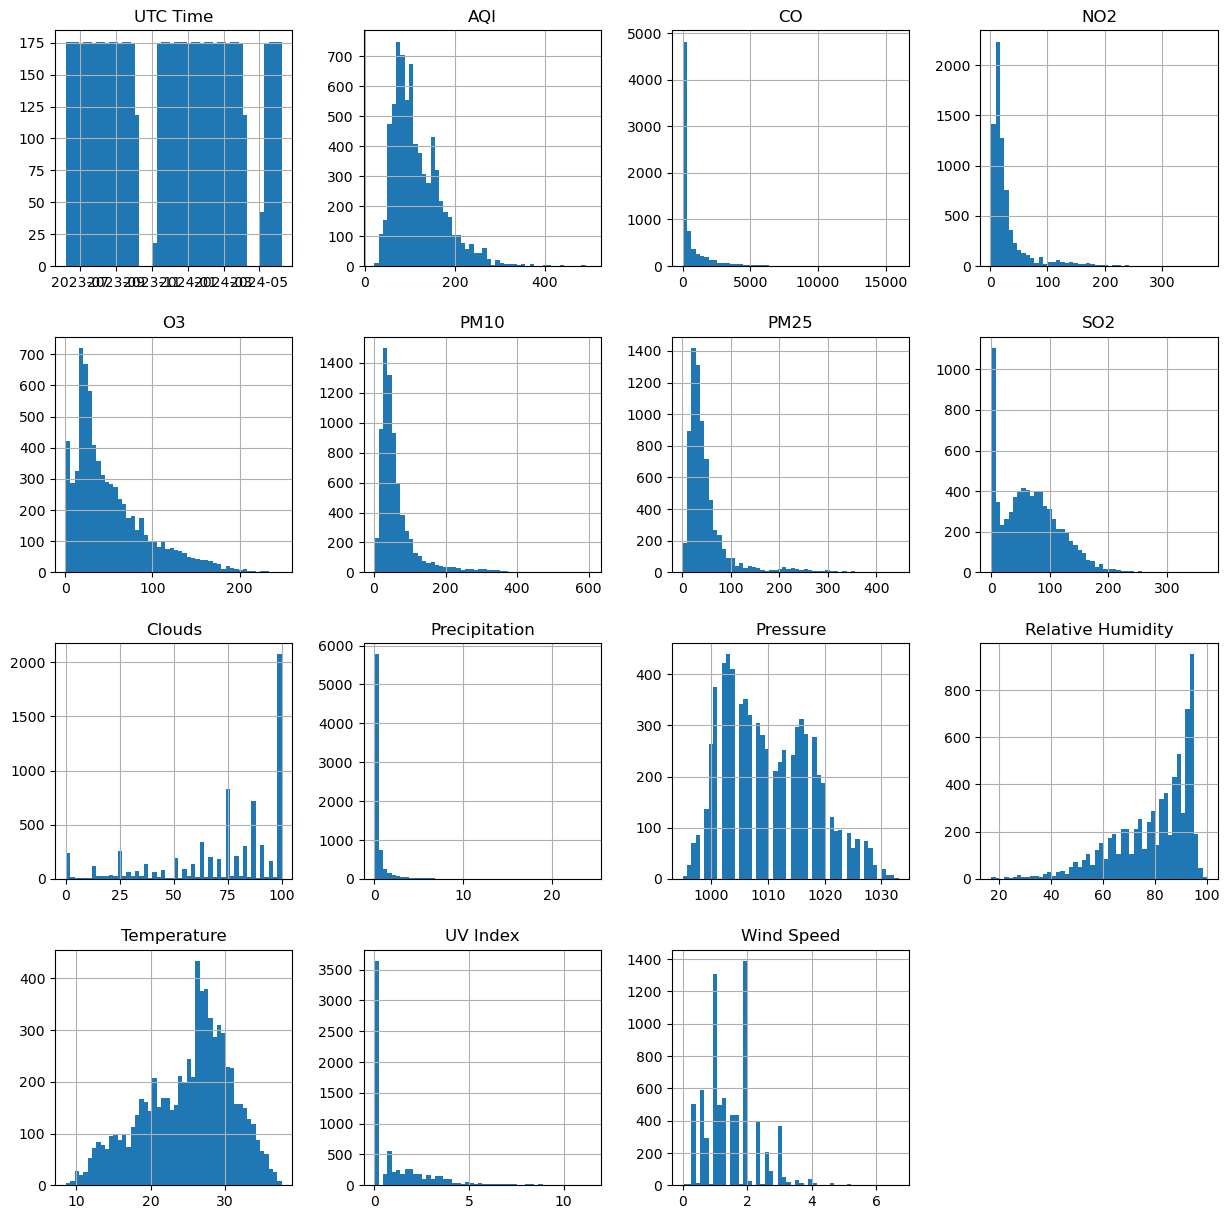

In [4]:
df.hist(bins=50, figsize=(15,15));

In [5]:
dataset_columns = df.columns.tolist()
dataset_columns

['UTC Time',
 'City',
 'Country Code',
 'Timezone',
 'AQI',
 'CO',
 'NO2',
 'O3',
 'PM10',
 'PM25',
 'SO2',
 'Clouds',
 'Precipitation',
 'Pressure',
 'Relative Humidity',
 'Temperature',
 'UV Index',
 'Wind Speed']

<Axes: >

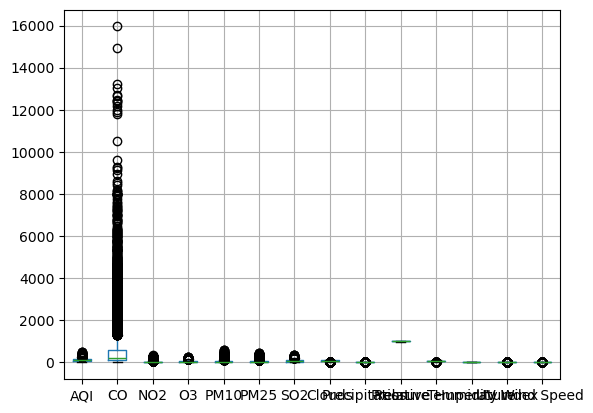

In [6]:
df.boxplot()

## Xác định biến mục tiêu

<Axes: >

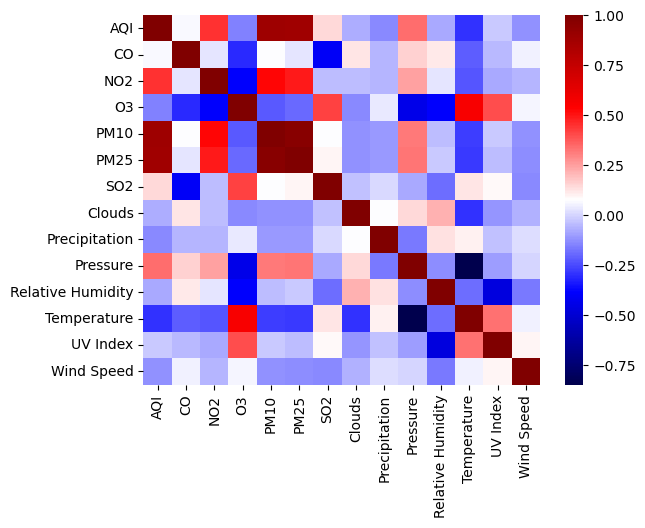

In [9]:
df_num = df[['AQI', 'CO', 'NO2',
       'O3', 'PM10', 'PM25', 'SO2', 'Clouds', 'Precipitation', 'Pressure',
       'Relative Humidity', 'Temperature', 'UV Index', 'Wind Speed']]
data = df_num.copy(deep=True)
sns.heatmap(data.corr(), cmap='seismic')

In [12]:
data.drop(columns=['CO', 'Clouds', 'UV Index', 'SO2'], inplace=True)

In [13]:
data.head()

,AQI,NO2,O3,PM10,PM25,Precipitation,Pressure,Relative Humidity,Temperature,Wind Speed
Local Time,,,,,,,,,,
2023-06-08 00:00:00,118,32.3,74.7,52.5,42.0,0.5,1004,87,29.3,1.33
2023-06-08 01:00:00,115,32.0,66.0,51.3,41.0,1.0,1004,88,29.0,1.00
2023-06-08 02:00:00,112,29.3,63.7,50.0,40.0,1.0,1003,89,28.9,0.66
2023-06-08 03:00:00,121,26.7,61.3,53.8,43.0,0.5,1003,90,28.7,0.33
2023-06-08 04:00:00,134,24.0,59.0,60.0,48.0,0.0,1003,92,28.6,1.20


In [16]:
from sklearn.preprocessing import LabelEncoder

# Encode non categorical values
values = data.values
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
values[:,4]

array([763., 747., 731., ...,  62.,  74., 107.], dtype=float32)

In [17]:
values

array([[118.  ,  32.3 ,  74.7 , ...,  87.  ,  29.3 ,   1.33],
       [115.  ,  32.  ,  66.  , ...,  88.  ,  29.  ,   1.  ],
       [112.  ,  29.3 ,  63.7 , ...,  89.  ,  28.9 ,   0.66],
       ...,
       [ 49.  ,  20.3 ,  35.2 , ...,  95.  ,  26.7 ,   2.  ],
       [ 51.  ,  20.  ,  29.7 , ...,  95.  ,  26.8 ,   1.66],
       [ 54.  ,  38.5 ,  39.1 , ...,  95.  ,  26.9 ,   1.33]],
      dtype=float32)